In [72]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob
import numpy as np
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
% matplotlib inline

## Read in all the images

In [59]:
cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

In [3]:
def data_look(car_list,notcar_list):
    data_dict = {}
    data_dict["n_cars"] = len(car_list)
    data_dict["n_notcars"] = len(notcar_list)
    image = cv2.imread(notcar_list[0])
    data_dict["image_shape"] = image.shape
    data_dict["data_type"] = image.dtype
    return data_dict

In [4]:
data_dict = data_look(cars,notcars)
print(data_dict)

{'data_type': dtype('uint8'), 'n_cars': 8792, 'n_notcars': 8968, 'image_shape': (64, 64, 3)}


## Set the parameters for feature extraction

In [90]:
cspace = 'YUV'
spatial_size = (32,32)
nbins = 32
bin_range = (0,256)
orient = 13
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL'

## Extract HOG features 

In [15]:
def get_hog_features(img,orient,pix_per_cell,cell_per_block,vis=True,feature_vec=True):
    if vis:
        features,hog_image = hog(img, orientations=orient,pixels_per_cell=(pix_per_cell,pix_per_cell)\
            ,cells_per_block=(cell_per_block,cell_per_block),visualise=vis,feature_vector=feature_vec,block_norm="L2-Hys")
        return features,hog_image
    else:
        features = hog(img,orientations=orient,pixels_per_cell=(pix_per_cell,pix_per_cell), \
                      cells_per_block=(cell_per_block,cell_per_block),visualise=vis,feature_vector=feature_vec,block_norm="L2-Hys")
        return features

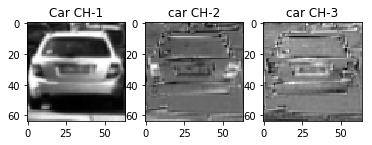

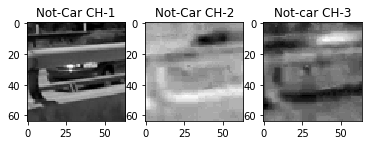

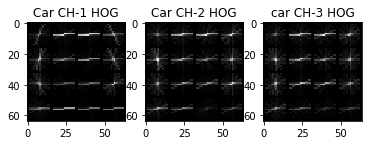

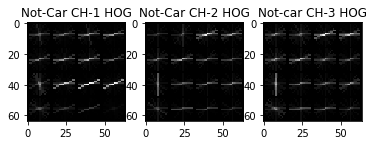

In [93]:
# choose two random indices
car_ind = np.random.randint(0,data_dict["n_cars"])
notcar_ind = np.random.randint(0,data_dict["n_notcars"])
# read the images
car_image = cv2.imread(cars[car_ind])
notcar_image = cv2.imread(notcars[notcar_ind])
cvt_car_image = cv2.cvtColor(car_image,cv2.COLOR_BGR2YUV)
cvt_notcar_image = cv2.cvtColor(notcar_image,cv2.COLOR_BGR2YUV)

car_hog_image = []
notcar_hog_image = []

for i in range(3):
    features,hog_image = get_hog_features(cvt_car_image[:,:,i],orient,pix_per_cell,cell_per_block,True,True)
    car_hog_image.append(hog_image)
    features,hog_image = get_hog_features(cvt_notcar_image[:,:,i],orient,pix_per_cell,cell_per_block,True,True)
    notcar_hog_image.append(hog_image)

# plot the image
fig = plt.figure()
plt.subplot(131)
plt.title('Car CH-1')
plt.imshow(cvt_car_image[:,:,0],cmap='gray')

plt.subplot(132)
plt.title('car CH-2')
plt.imshow(cvt_car_image[:,:,1],cmap='gray')

plt.subplot(133)
plt.title('car CH-3')
plt.imshow(cvt_car_image[:,:,2],cmap='gray')

fig = plt.figure()
plt.subplot(131)
plt.title('Not-Car CH-1')
plt.imshow(cvt_notcar_image[:,:,0],cmap='gray')

plt.subplot(132)
plt.title('Not-Car CH-2')
plt.imshow(cvt_notcar_image[:,:,1],cmap='gray')

plt.subplot(133)
plt.title('Not-car CH-3')
plt.imshow(cvt_notcar_image[:,:,2],cmap='gray')


fig = plt.figure()
plt.subplot(131)
plt.title('Car CH-1 HOG')
plt.imshow(car_hog_image[0],cmap='gray')

plt.subplot(132)
plt.title('Car CH-2 HOG')
plt.imshow(car_hog_image[1],cmap='gray')

plt.subplot(133)
plt.title('car CH-3 HOG')
plt.imshow(car_hog_image[2],cmap='gray')


fig = plt.figure()
plt.subplot(131)
plt.title('Not-Car CH-1 HOG')
plt.imshow(notcar_hog_image[0],cmap='gray')

plt.subplot(132)
plt.title('Not-Car CH-2 HOG')
plt.imshow(notcar_hog_image[1],cmap='gray')

plt.subplot(133)
plt.title('Not-car CH-3 HOG')
plt.imshow(notcar_hog_image[2],cmap='gray')





## Extract histograms of pixel intensity features

In [16]:
def color_hist(img,nbins=32,bin_range=(0,256)):
    channel_1_hist = np.histogram(img[:,:,0],bins=32,range=bin_range)
    channel_2_hist = np.histogram(img[:,:,1],bins=32,range=bin_range)
    channel_3_hist = np.histogram(img[:,:,2],bins=32,range=bin_range)
    hist_feature = np.concatenate([channel_1_hist[0],channel_2_hist[0],channel_3_hist[0]])
    
    return hist_feature

## Extract spatial features

In [17]:
def spatial_feature(img,size=(32,32)):
    # return a one dimensional feature vector
    features = cv2.resize(img,size).ravel()
   
    return features

## Combine features

In [18]:
# hog_channel can take values of 0, 1, 2, or "ALL"
# meaning that you extract HOG features from the first, second, third, or all color channels respectively.
def extract_features(imgs,cspace,spatial_size,nbins,bin_range,orient,pix_per_cell,cell_per_block,hog_channel,\
                     spatial_feat=True,hist_feat=True,hog_feat=True):
    
    feature_list = []
    for filename in imgs:
        features = []
        image = cv2.imread(filename)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
       
        # Apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
            if cspace == 'YCrCb':
                image = cv2.cvtColor(image,cv2.COLOR_RGB2YCrCb)
            if cspace == 'YUV':
                image = cv2.cvtColor(image,cv2.COLOR_RGB2YUV)
       
        # Compute spatial features if flag is set
        if spatial_feat == True:
            feature = spatial_feature(image,spatial_size)
            features.append(feature)
        
        # Compute histogram features if flag is set
        if hist_feat == True:
            feature = color_hist(image,nbins,bin_range).astype(np.float64)
            features.append(feature)
          
        
        # Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(image.shape[2]):
                    feature = get_hog_features(image[:,:,channel],orient,pix_per_cell,cell_per_block,vis=False)
                    hog_features.append(feature)
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(image[:,:,hog_channel],orient,pix_per_cell,cell_per_block,vis=False)
            features.append(hog_features)
        
        feature_list.append(np.concatenate(features))
        
    return feature_list

## Extract images features

In [20]:
car_features = extract_features(cars, cspace, spatial_size, nbins, bin_range, orient\
             , pix_per_cell, cell_per_block, hog_channel)

In [21]:
notcar_features = extract_features(notcars,cspace, spatial_size, nbins, bin_range, orient\
             , pix_per_cell, cell_per_block, hog_channel)

In [22]:
X = np.vstack((car_features,notcar_features)).astype(np.float64)

In [23]:
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

## Normalize Features

In [25]:
scaler = StandardScaler()

scaler.fit(X)

# data = (data - mean) / np.sqrt(var)
scaled_X = scaler.transform(X)

## Split data into randomized training and test sets

In [26]:
from sklearn.model_selection import train_test_split
rand_state = np.random.randint(0, 100)
X_train,X_test,y_train,y_test = train_test_split(scaled_X,y,test_size=0.2,random_state=rand_state)

## Train the classifier and save the result 

In [18]:
from sklearn.svm import LinearSVC
# Use a linear SVC 
svc = LinearSVC()

In [19]:
svc.fit(X_train,y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [20]:
svc.score(X_test, y_test)

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.


0.99042792792792789

In [25]:
joblib.dump(svc, 'classifier.pkl') 

['classifier.pkl']

## check the score of the SVC

In [11]:
svc = joblib.load('classifier.pkl') 

In [27]:
print('SVC predicts: ', svc.predict(X_test[0:10]))
print('For these 10 labels:', y_test[0:10])

SVC predicts:  [ 0.  1.  1.  0.  1.  1.  1.  1.  1.  0.]
For these 10 labels: [ 0.  1.  1.  0.  1.  1.  1.  1.  1.  0.]


In [37]:
def convert_color(img,conv):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img,cv2.COLOR_RGB2YUV)

In [38]:
def find_cars(img,scale,orient,pix_per_cell,cell_per_block,svc,cells_per_step,ystart,ystop,xstart,xstop):
    
    bbox_list = []
    
    draw_img = img.copy()
    window = 64
    features = []

    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    img_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        img_tosearch = cv2.resize(img_tosearch,(np.int(img_tosearch.shape[1]/scale), np.int(img_tosearch.shape[0]/scale)))
        
    ch1 = img_tosearch[:,:,0]
    ch2 = img_tosearch[:,:,1]
    ch3 = img_tosearch[:,:,2]
    
    nx_blocks = (img_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    ny_blocks = (img_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1
    
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    
    nx_steps = (nx_blocks - nblocks_per_window) // cells_per_step + 1
    ny_steps = (ny_blocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1,orient,pix_per_cell,cell_per_block,vis=False,feature_vec=False)
    hog2 = get_hog_features(ch2,orient,pix_per_cell,cell_per_block,vis=False,feature_vec=False)
    hog3 = get_hog_features(ch3,orient,pix_per_cell,cell_per_block,vis=False,feature_vec=False)
   
  
    for x in range(nx_steps):
        for y in range(ny_steps):
           
            features = []
            ypos = y * cells_per_step
            xpos = x * cells_per_step
        
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            # Extract the image patch
            subimg = img_tosearch[ytop:ytop+window,xleft:xleft+window]
           
            # Get features
            feature = spatial_feature(subimg,spatial_size).astype(np.float64)
            features.append(feature)
        
            hist_features = color_hist(subimg,nbins,bin_range).astype(np.float64)
            features.append(hist_features)
            
            # Extract HOG for this patch
            hog1_feature = hog1[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            hog2_feature = hog2[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            hog3_feature = hog3[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
           
           
            features.append(hog1_feature)
            features.append(hog2_feature)
            features.append(hog3_feature)
    
            features = np.hstack(features).reshape(1,-1)
            # Scale features
            scaled_feature = scaler.transform(features)
            predict = svc.predict(scaled_feature)
            
            
            if predict:
                score = svc.decision_function(scaled_feature)
                #print(score)
                
                xleft_draw = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                window_draw = np.int(window * scale)
                left_top = (xleft_draw+xstart, ytop_draw+ystart)
                right_bottom = (xleft_draw+window_draw+xstart,ytop_draw+window_draw+ystart)
                bbox_list.append((left_top,right_bottom))
                cv2.rectangle(draw_img,(xleft_draw+xstart, ytop_draw+ystart),(xleft_draw+window_draw+xstart,ytop_draw+window_draw+ystart)\
                    ,(0,0,255),6) 
   
    return draw_img,bbox_list

## Try different scales on different images

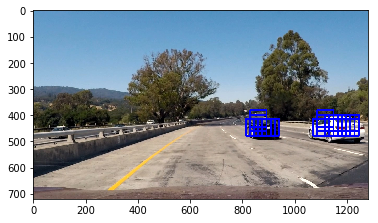

In [61]:
image = cv2.imread('test_images/test1.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
scale = 1
draw_img,box_list = find_cars(image,scale,13,16,2,svc,1,350,478,300,1280)
cv2.line(draw_img,(400,0),(400,720),color=(0,255,0),thickness=1)
plt.imshow(draw_img)

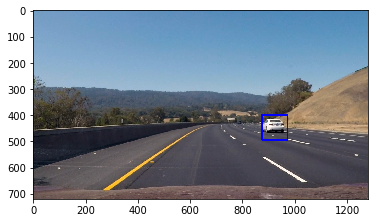

In [62]:
image = cv2.imread('test_images/test3.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
scale = 1.5
draw_img,box_list = find_cars(image,scale,13,16,2,svc,1,350,542,300,1280)
plt.imshow(draw_img)

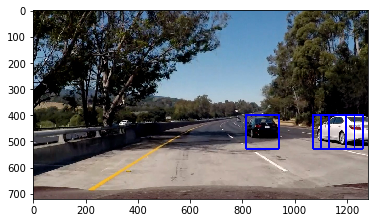

In [63]:
image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
scale = 2
draw_img,box_list = find_cars(image,scale,13,16,2,svc,1,400,656,300,1280)
plt.imshow(draw_img)

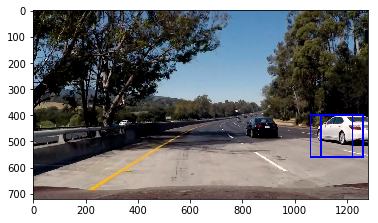

In [106]:
image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
scale = 2.5
draw_img,box_list = find_cars(image,scale,13,16,2,svc,1,400,720,300,1280)
plt.imshow(draw_img)

## Combine different scales

In [98]:
image = cv2.imread('test_images/test4.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
bbox_list = []
scales = [1,1.5,2,2.5]
draw_img,box_list = find_cars(image,scales[0],13,16,2,svc,1,350,478,300,1280)
bbox_list.extend(box_list)
draw_img,box_list = find_cars(image,scales[1],13,16,2,svc,1,350,542,300,1280)
bbox_list.extend(box_list)
draw_img,box_list = find_cars(image,scales[2],13,16,2,svc,1,400,656,300,1280)
bbox_list.extend(box_list)
draw_img,box_list = find_cars(image,scales[3],13,16,2,svc,1,400,720,300,1280)
bbox_list.extend(box_list)

## Some useful function

In [50]:
def add_heat(heatmap,bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1],box[0][0]:box[1][0]] += 1
        
    return heatmap

In [51]:
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [53]:
def draw_labeled_bboxes(img, labeled_array,num_features):
    # Iterate through all detected cars
    for car_number in range(1,num_features+1):
        nonzero = np.nonzero(labeled_array==car_number)
        nonzero_x = nonzero[1]
        nonzero_y = nonzero[0]
        # Define a bounding box based on min/max x and y
        top_left = (np.min(nonzero_x),np.min(nonzero_y))
        bottom_right = (np.max(nonzero_x),np.max(nonzero_y))
        if (np.max(nonzero_x) - np.min(nonzero_x) >= 64) and (np.max(nonzero_y) - np.min(nonzero_y) >= 64):
            cv2.rectangle(img, top_left, bottom_right, (0,0,255), 6)
    return img

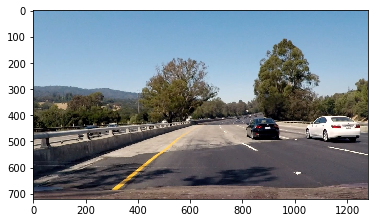

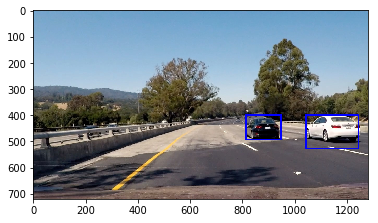

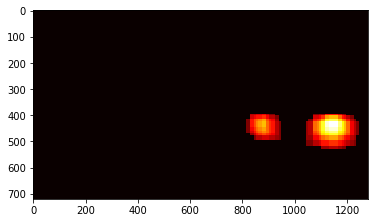

In [100]:
plt.imshow(image)
heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap,bbox_list)
heatmap = apply_threshold(heatmap,3)
labeled_array, num_features = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labeled_array, num_features)
plt.figure()
plt.imshow(draw_img)
plt.figure()
plt.imshow(heatmap, cmap='hot')

In [52]:
def process_image(image):
    bbox_list = []
    scales = [1,1.5,2,2.5]
    draw_img,box_list = find_cars(image,scales[0],13,16,2,svc,1,350,478,300,1280)
    bbox_list.extend(box_list)
    draw_img,box_list = find_cars(image,scales[1],13,16,2,svc,1,350,542,300,1280)
    bbox_list.extend(box_list)
    draw_img,box_list = find_cars(image,scales[2],13,16,2,svc,1,400,656,300,1280)
    bbox_list.extend(box_list)
    draw_img,box_list = find_cars(image,scales[3],13,16,2,svc,1,400,720,300,1280)
    
    curr_heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    curr_heatmap = add_heat(curr_heatmap,bbox_list)
    car.update_heatmap(curr_heatmap)
    new_heatmap = car.add_heat()

    thres_heatmap = apply_threshold(new_heatmap,18)
    
    #plt.figure()
    #plt.imshow(thres_heatmap,cmap='hot')
    
    labeled_array, num_features = label(thres_heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labeled_array, num_features)
    return draw_img

In [54]:
class Car():
    def __init__(self):
        # save previous heatmap in self.heatmaps
        self.heatmaps = []
        
    def add_heat(self):
        new_heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
       
        for heatmap in self.heatmaps:
            new_heatmap = new_heatmap + heatmap
           
        return new_heatmap
    
    
    def update_heatmap(self,curr_heatmap):
        if len(self.heatmaps) == 6:
            self.heatmaps.pop(0)
        self.heatmaps.append(curr_heatmap)
        
    def num_heatmap(self):
        return len(self.heatmaps)

In [58]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
car = Car()
output = 'output.mp4'
#heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
clip1 = VideoFileClip("project_video.mp4")
new_clip = clip1.fl_image(process_image)
new_clip.write_videofile(output,audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [21:14<00:01,  1.02s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

